In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

from numpy import genfromtxt


import pandas as pd

from mpl_toolkits import mplot3d
#%matplotlib notebook

import math

#import cv2
import pims
from PIL import Image

import skimage

import json

#own modules / functions
import sys

pythonPackagePath = "/Users/johannesschoeneberg/git/pyLattice/src/python/"
sys.path.append(pythonPackagePath+"/modules")
import TiffProcessing as tiffproc
import InputProcessing as inproc
sys.path.append(pythonPackagePath+"/classes")
import Track

# input data

In [45]:
#inputParameters = pd.read_csv(pythonPackagePath+'../../input/_inputParameters.csv',names=['key','value'])
#inputParameters = pd.read_csv(pythonPackagePath+'../../input/big_data/_inputParameters.csv',names=['key','value'])
#inputParameters = pd.read_csv(pythonPackagePath+'../../input/big_data_cutoff7000_bleachCorrected/_inputParameters.csv',names=['key','value'])
#inputParameters = pd.read_csv(pythonPackagePath+'../../input/big_data_DMSO_cutoff7000_bleachCorrected/_inputParameters.csv',names=['key','value'])
#inputParameters = pd.read_csv(pythonPackagePath+'../../input/big_data_JASP_cutoff7000_bleachCorrected/_inputParameters.csv',names=['key','value'])
inputParameters = pd.read_csv(pythonPackagePath+'../../input/big_data_LY_cutoff7000_bleachCorrected/_inputParameters.csv',names=['key','value'])

inputDataFolder = inproc.getInputParameter(inputParameters,"inputDataFolder")
outputDataFolder = inproc.getInputParameter(inputParameters,"outputDataFolder")
print(inputDataFolder)
print(outputDataFolder)
inputDataFolder = inputDataFolder.replace("6big","Samsung_T3b")#'/Volumes/Samsung_T3b/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/output/'
outputDataFolder = outputDataFolder.replace("6big","Samsung_T3b")#'/Volumes/Samsung_T3b/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/output/'
print(inputDataFolder)
print(outputDataFolder)

trackingCsvFilename = inproc.getInputParameter(inputParameters,"trackingCsvFilename")
trackingCsvFilenameProcessed = inproc.getInputParameter(inputParameters,"trackingCsvFilenameProcessed")

slave_outputDataFolder  = inproc.getInputParameter(inputParameters,"slave_outputDataFolder")
master_outputDataFolder  = inproc.getInputParameter(inputParameters,"master_outputDataFolder")

slave_uniqueFilenameString = inproc.getInputParameter(inputParameters,"slave_uniqueFilenameString")
master_uniqueFilenameString = inproc.getInputParameter(inputParameters,"master_uniqueFilenameString")


slave_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"slave_trackingProcessedBildFilename")
master_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"master_trackingProcessedBildFilename")



framerate_msec = float(inproc.getInputParameter(inputParameters,"framerate_msec"))
movieLength = int(inproc.getInputParameter(inputParameters,"movieLength"))


print(framerate_msec)


/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/
/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/output/
/Volumes/Samsung_T3b/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/
/Volumes/Samsung_T3b/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/output/
5689.0


# postprocess the thresholds so that they work !

In [50]:
#print(averagedThresholdOverAllFrames)
#print(averagedThresholdOverAllFrames)
# flip the z (mirror it)
averagedThresholdOverAllFrames[:,2]=abs(averagedThresholdOverAllFrames[:,2]-120)
#print()
#print(averagedThresholdOverAllFrames)

# read the tracking data for splitting

In [51]:
# read the raw csv data for further processing

trackId = 226

path = outputDataFolder+'/'+trackingCsvFilename
print(path)

data = pd.read_csv(path,header=0)
#data.columns = ["trackId","tracklength","time[s]","frameId","lifetime","catIdx","m_x",'m_y',"m_z","m_A","m_c","m_pval_Ar","s_x",'s_y',"s_z","s_A","s_c","s_pval_Ar"]
#trackIds = data.drop_duplicates(subset='trackId')['trackId'].values
#longtracks = data[data['tracklength'] >= 10]
#print(len(longtracks))
#print(len(np.unique(data['trackId'].values)))
#print(np.unique(data['trackId'].values))
#data[0:5]

allTrackIds = np.unique(data['trackId'].values)
#data[data['trackId'] == trackId]
#print(trackData)
#track = Track.Track(trackData)
longtracks = data[data['tracklength'] >= 10]
allLongTrackIds = np.unique(longtracks['trackId'].values)
print(len(allTrackIds))
print(len(allLongTrackIds))

allLongTrackLengths = []
for trackId in allLongTrackIds:
    trackData = data[data['trackId'] == trackId]
    trackLength = trackData['tracklength'].values[0]
    allLongTrackLengths.append(trackLength)


/Volumes/Samsung_T3b/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/output//trackedFeatures.csv
21035
1368


In [52]:

lifetimeCohorts = [[0, 6], [6,12],[12,18],[18,24],[24,30],[30,70]] #frames



trackIdsAssignedToCohorts = []
for i in range(0,len(lifetimeCohorts)):
    trackIdsAssignedToCohorts.append(np.array([]))

for k in range(0,len(allLongTrackLengths)):
    for i in range(0,len(lifetimeCohorts)):
        tracklength = allLongTrackLengths[k]-6
        trackId = allLongTrackIds[k]
        #print(tracklength)
        if((tracklength >lifetimeCohorts[i][0]) & (tracklength <=lifetimeCohorts[i][1])):
            trackIdsAssignedToCohorts[i] = np.append(trackIdsAssignedToCohorts[i],trackId)

print(trackIdsAssignedToCohorts)

[array([   217.,    218.,    219.,    221.,    222.,    223.,    224.,
          226.,    227.,    228.,    229.,    230.,    231.,    232.,
          233.,    234.,    235.,    236.,    237.,    238.,    239.,
          240.,    241.,    242.,    243.,    245.,    246.,    248.,
          249.,    250.,    251.,    252.,    253.,    254.,    255.,
          256.,    257.,    258.,    260.,    261.,    262.,    263.,
          264.,    267.,    268.,    269.,    270.,    271.,    272.,
          273.,    274.,    275.,    276.,    277.,    278.,    279.,
          280.,    281.,    282.,    283.,    284.,    285.,    286.,
          287.,    288.,    289.,    290.,    291.,    292.,    293.,
          294.,    296.,    297.,    298.,    299.,    300.,    301.,
          302.,    303.,    304.,    307.,    308.,    310.,    314.,
          315.,    316.,    317.,    318.,    319.,    321.,    322.,
          323.,    324.,    325.,    326.,    327.,    328.,    329.,
          330.,    

566
500
162
74
37
29


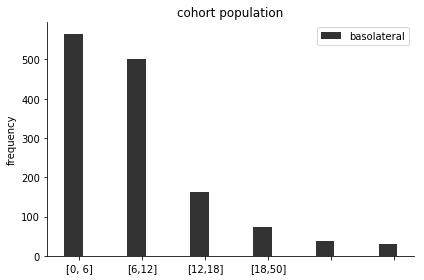

In [53]:
# data to plot

cohorts_n = []
#print(trackIdsAssignedToCohorts_baso)
for cohortIdArray in trackIdsAssignedToCohorts:
    print(len(cohortIdArray))
    cohorts_n.append(len(cohortIdArray))

A = (cohorts_n[0], cohorts_n[1],cohorts_n[2],cohorts_n[3],cohorts_n[4],cohorts_n[5])
n_groups = len(A) 
    
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.8
 
rects1 = plt.bar(index, A, bar_width,
                 alpha=opacity,
                 color='k',
                 label='basolateral')




 
#plt.xlabel('Person')
plt.ylabel('frequency')
plt.title('cohort population')
plt.xticks(index + bar_width/3, ('[0, 6]', '[6,12]','[12,18]', '[18,50]'))

plt.legend()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
 
plt.tight_layout()
plt.show()

